In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from random import random
import seaborn as sns
%matplotlib inline

data_dir = '/kaggle/input/titanic/'
train_file = 'train.csv'
test_file = 'test.csv'

# Read files
train_df = pd.read_csv(data_dir + train_file)
test_df = pd.read_csv(data_dir + test_file)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return ms

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


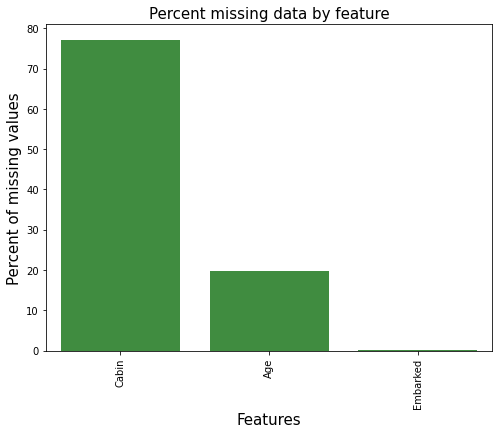

In [3]:
missingdata(train_df)

,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


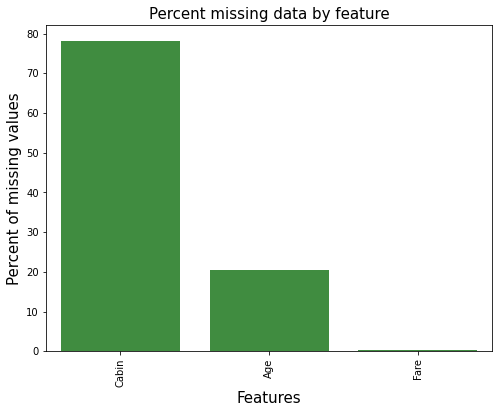

In [4]:
missingdata(test_df)

# Fill missing values

In [5]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace = True)
train_df['Fare'].fillna(train_df['Fare'].median(), inplace = True)

test_df['Embarked'].fillna(test_df['Embarked'].mode()[0], inplace = True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace = True)

train_df['Age'].fillna(train_df['Age'].median(), inplace = True)
test_df['Age'].fillna(test_df['Age'].median(), inplace = True)

# Feature Engineering

In [6]:
   
import re
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

def feature_engineering(data):
    
    data['FamiliySize'] = data['SibSp'] + data['Parch'] + 1
    
    data['Title'] = data['Name'].apply(get_title)
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    
    data['Age_bin'] = pd.cut(data['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])
    data['Fare_bin'] = pd.cut(data['Fare'], bins=[0,7.91,14.45,31,120], labels=['low_fare','median_fare',
                                                                                      'average_fare','high_fare'])

In [7]:
feature_engineering(train_df)
feature_engineering(test_df)
Y_test_id = test_df['PassengerId'].to_numpy()
train_df = train_df.drop(columns = ['PassengerId', 'Name', 'Age', 'Fare', 'Cabin', 'Ticket'])
test_df = test_df.drop(columns = ['PassengerId', 'Name', 'Age', 'Fare', 'Cabin', 'Ticket'])


In [8]:
train_df.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,FamiliySize,Title,Age_bin,Fare_bin
0,0,3,male,1,0,S,2,Mr,Adult,low_fare
1,1,1,female,1,0,C,2,Mrs,Adult,high_fare
2,1,3,female,0,0,S,1,Miss,Adult,median_fare
3,1,1,female,1,0,S,2,Mrs,Adult,high_fare
4,0,3,male,0,0,S,1,Mr,Adult,median_fare


In [9]:
test_df.head()

,Pclass,Sex,SibSp,Parch,Embarked,FamiliySize,Title,Age_bin,Fare_bin
0,3,male,0,0,Q,1,Mr,Adult,low_fare
1,3,female,1,0,S,2,Mrs,Elder,low_fare
2,2,male,0,0,Q,1,Mr,Elder,median_fare
3,3,male,0,0,S,1,Mr,Adult,median_fare
4,3,female,1,1,S,3,Mrs,Adult,median_fare


### Categorize str columns

In [10]:
train_df = pd.get_dummies(train_df, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

test_df = pd.get_dummies(test_df, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

In [11]:
train_df.head()

,Survived,Pclass,SibSp,Parch,FamiliySize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,...,Age_type_Teenage,Age_type_Adult,Age_type_Elder,Em_type_C,Em_type_Q,Em_type_S,Fare_type_low_fare,Fare_type_median_fare,Fare_type_average_fare,Fare_type_high_fare
0,0,3,1,0,2,0,1,0,0,1,...,0,1,0,0,0,1,1,0,0,0
1,1,1,1,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
2,1,3,0,0,1,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
3,1,1,1,0,2,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,0,3,0,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0


In [12]:
test_df.head()

,Pclass,SibSp,Parch,FamiliySize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Age_type_Teenage,Age_type_Adult,Age_type_Elder,Em_type_C,Em_type_Q,Em_type_S,Fare_type_low_fare,Fare_type_median_fare,Fare_type_average_fare,Fare_type_high_fare
0,3,0,0,1,0,1,0,0,1,0,...,0,1,0,0,1,0,1,0,0,0
1,3,1,0,2,1,0,0,0,0,1,...,0,0,1,0,0,1,1,0,0,0
2,2,0,0,1,0,1,0,0,1,0,...,0,0,1,0,1,0,0,1,0,0
3,3,0,0,1,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
4,3,1,1,3,1,0,0,0,0,1,...,0,1,0,0,0,1,0,1,0,0


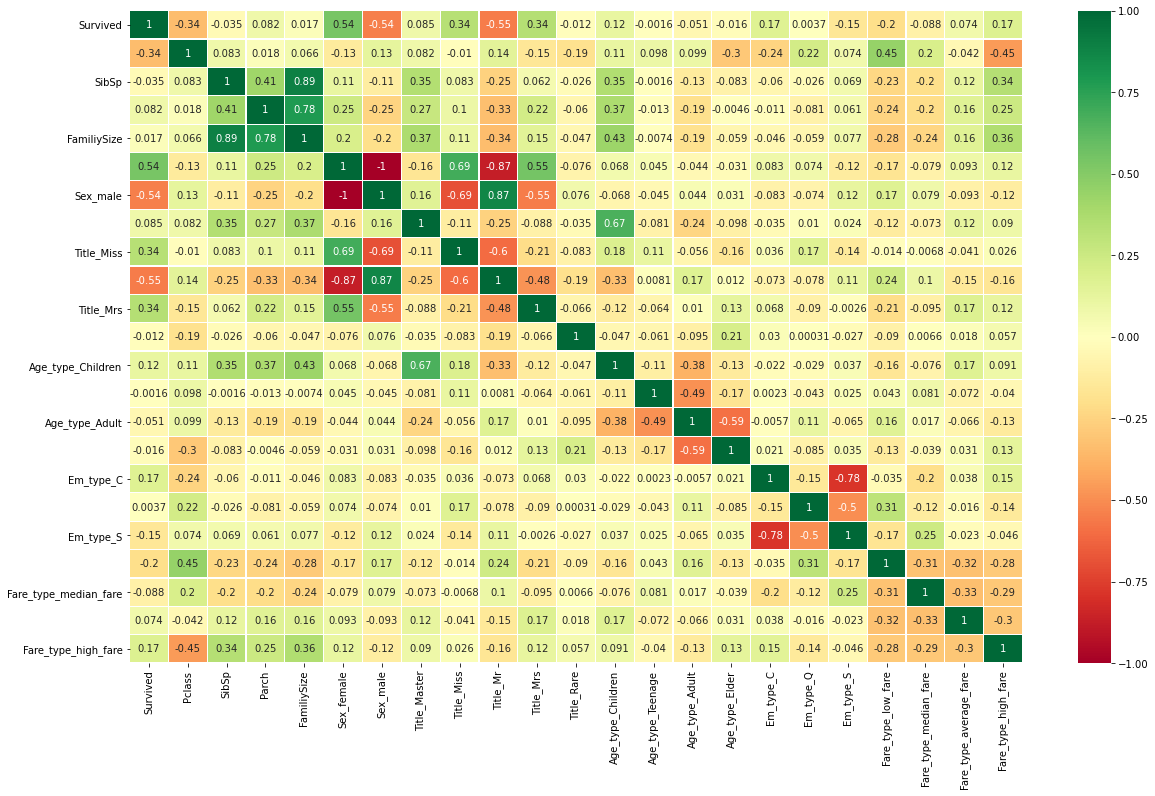

In [13]:
sns.heatmap(train_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

# Split data into train and test

In [14]:
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.metrics import accuracy_score  #for accuracy_score
from sklearn.model_selection import train_test_split #for split the data


In [15]:
#features = train_df.drop('Survived', axis = 1)
#target_feature = train_df['Survived']
#X_train,X_test,Y_train,Y_test = train_test_split(features,target_feature,test_size=0.3,random_state=42)

Y_train = train_df['Survived']
X_train = train_df.drop(columns = ['Survived'])
X_test = test_df

X_train = X_train.to_numpy().astype('float32')
X_test = X_test.to_numpy().astype('float32')
Y_train = Y_train.to_numpy().astype('float32').reshape((X_train.shape[0],1))

print(f"There are {X_train.shape[0]} train values.")
print(f"There are {X_test.shape[0]} test values.")

There are 891 train values.
There are 418 test values.


# Model

## LogisticRegression

In [16]:
from sklearn.linear_model import LogisticRegression # Logistic Regression

model = LogisticRegression()
model.fit(X_train, Y_train)

predict_lr = model.predict(X_test)
#print('The accuracy of the Sequential Model is',round(accuracy_score(predict_lr,Y_test)*100,2))


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


# Build Submission

In [17]:
Y_test_id = Y_test_id.reshape((X_test.shape[0],1)).astype('int')

output = predict_lr.reshape((X_test.shape[0],1)).astype('int')

output_final = np.hstack((Y_test_id, output))

output_df = pd.DataFrame(columns = ['PassengerId', 'Survived'], data = output_final)
output_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [18]:
output_df.to_csv('output_final.csv', index = False, index_label = False)